In [ ]:
% setup MRI-education-resources path and requirements
cd ../
startup

loading image
loading signal


# Artifacts

This notebook includes a simulation of various MRI artifacts, as well as a high-level Artifact Comparison below.  The wikipedia entry https://en.wikipedia.org/wiki/MRI_artifact is also very comprehensive.

## Learning Goals

1. Identify artifacts and how to mitigate them


## Introduction

Many of the artifacts that occur in MRI can be understood and analyzed using the k-space perspective.  In particular, they can be understood as the k-space data being modified by some function.  This is described mathematically in 
[MRI Signal Equation and K-space](./MRI%20Signal%20Equation.ipynb) in the K-space Data Weighting section.

## Artifact Comparison

| Artifact Name | Appearance | Frequency or Phase encoding |
|---|---|---|
| Aliasing | Signal folds across image | Phase encoding |
| Spike Noise | Specific spatial frequency on top of entire image | N/A |
| Gibbs Ringing/Truncation | Ripples/ringing at sharp edges | N/A |
| RF interference/Zipper | Line of noisy signal on top of image | At a specific frequency encoding location |
| Motion/Flow | Copies or "Ghosts" of image regions that are changing due to motion or flow | Phase encoding |
| Displacement/Distortion | Shifts in location due to chemical shift (fat) and off-resonance (e.g. magnetic susceptibility differences) |  Frequency encoding (2DFT), Phase encoding (EPI) |
| T2* | Signal loss around magnetic suscpetibility differences (e.g. implants, air) | N/A |
|  Slice Misregistration | Slice shifting due to chemical shift or off-resonance | N/A | 
| Dielectric Shading | Shading across entire image, particularly large FOV, higher B0 | N/A |
| Boundary Artifacts | Artificial dark lines at tissue boundaries due to inversion or chemical shift | N/A |
| Gradient non-linearity | Distortion of subject, particularly near edges of large FOV | N/A |

## Simulations of Artifacts

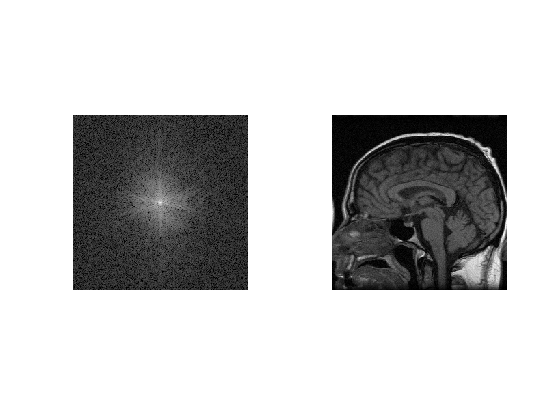

In [ ]:
% load k-space data
dataname = 'Data/se_t1_sag_data';
load(dataname)
kdata = data;
S = size(kdata);

im_original = ifft2c(kdata);

subplot(121)
imagesc(log(abs(kdata)), [0 max(log(abs(kdata(:))))])
colormap(gray), axis equal tight off
subplot(122)
imagesc(abs(im_original), [0 max(abs(im_original(:)))])
colormap(gray), axis equal tight off


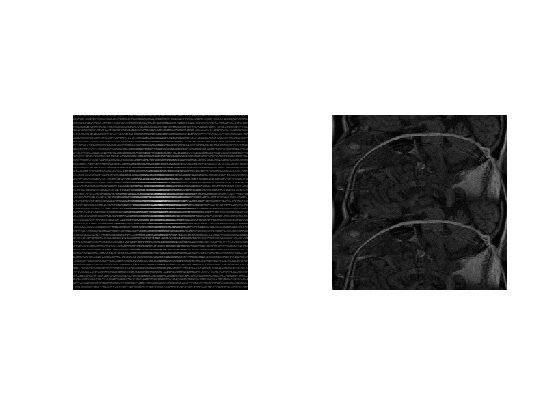

In [35]:
%% aliasing
N_undersamp = 2;  % >= 1
data_undersamp = zeros(size(kdata));
Iundersamp = 1:N_undersamp:S(1);
data_undersamp(round(Iundersamp),:) = kdata(round(Iundersamp),:);
im_undersamp = ifft2c(data_undersamp);


subplot(121)
imagesc(log(abs(data_undersamp)), [0 max(log(abs(kdata(:))))])
colormap(gray), axis equal tight off
subplot(122)
imagesc(abs(im_undersamp), [0 max(abs(im_original(:)))])
colormap(gray), axis equal tight off



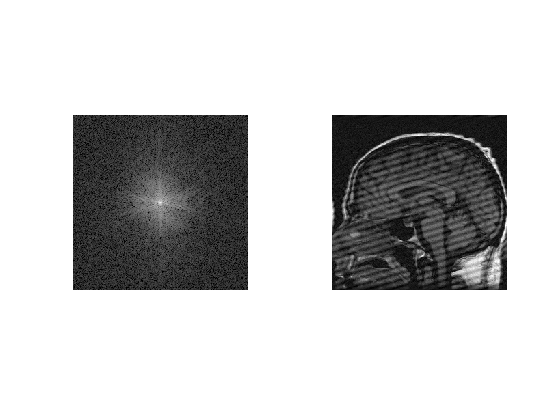

In [3]:
%% spike noise
spike_location = [.6 .53];

data_spike = zeros(size(kdata));
data_spike(round(S(1)*spike_location(1)), round(S(2)*spike_location(2))) = max(kdata(:))/1.5;
im_spike = ifft2c(kdata + data_spike);


subplot(121)
imagesc(log(abs(kdata + data_spike)), [0 max(log(abs(kdata(:))))])
colormap(gray), axis equal tight off
subplot(122)
imagesc(abs(im_spike), [0 max(abs(im_original(:)))])
colormap(gray), axis equal tight off



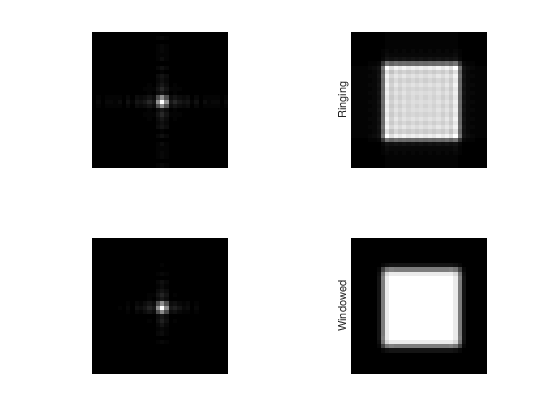

In [25]:
%% Ringing (with rect object)
N = 32;
kx = [-N/2:N/2-1]/N;
N_rect = N/2+2;
kdata = sinc(kx *N_rect).' * sinc(kx *N_rect);

rect_ringing = ifft2c(kdata);

subplot(221)
imagesc((abs(kdata)), [0 (1)])
colormap(gray), axis equal tight off
subplot(222)
imagesc(abs(rect_ringing), [0 max(abs(rect_ringing(:)))])
colormap(gray), axis equal tight off
ylabel('Ringing')

kdata_windowed = kdata .* (hamming(N) * hamming(N).');
rect_windowed = ifft2c(kdata_windowed);


subplot(223)
imagesc((abs(kdata_windowed)), [0 (1)])
colormap(gray), axis equal tight off
subplot(224)
imagesc(abs(rect_windowed), [0 max(abs(rect_windowed(:)))])
colormap(gray), axis equal tight off
ylabel('Windowed')


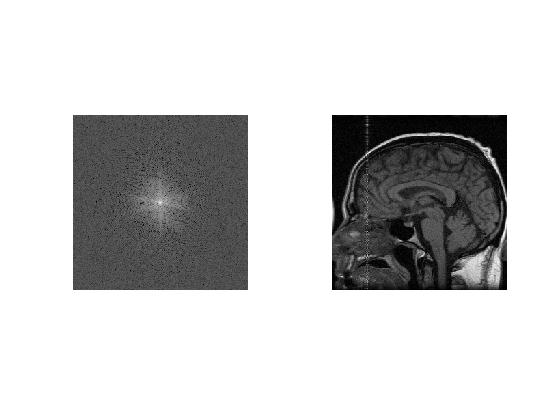

In [26]:
%% RF interference
relative_RF_frequency = 0.6;

%single frequency, phase modulated
ph_int = pi*rand(S(1),1);
rfint = exp(i*2*pi* [1:S(1)] *relative_RF_frequency/2 ) *  max(abs(kdata(:)))/S(1)/1.5;
data_rfint = repmat(rfint, [S(1), 1]) .* repmat(exp(i*ph_int), [1, S(2)]);
im_rfint = ifft2c(kdata + data_rfint);

figure
subplot(121)
imagesc(log(abs(kdata + data_rfint)), [0 max(log(abs(kdata(:))))])
colormap(gray), axis equal tight off
subplot(122)
imagesc(abs(im_rfint), [0 max(abs(im_original(:)))])
colormap(gray), axis equal tight off

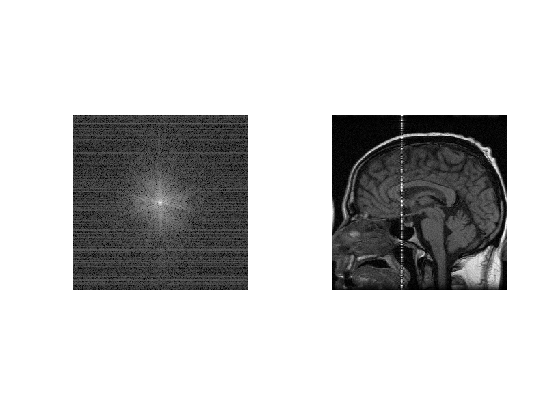

In [22]:
% RF interference -simulate amplitude modulated interference
relative_RF_frequency = 0.2;
rfint = exp(i*2*pi* [1:S(1)]/S(1) * S(1)*relative_RF_frequency/2) *  max(abs(kdata(:)))/S(1)/3;
data_rfint = randn(S(1),1) * rfint;
im_rfint = ifft2c(kdata + data_rfint);

figure
subplot(121)
imagesc(log(abs(kdata + data_rfint)), [0 max(log(abs(kdata(:))))])
colormap(gray), axis equal tight off
subplot(122)
imagesc(abs(im_rfint), [0 max(abs(im_original(:)))])
colormap(gray), axis equal tight off

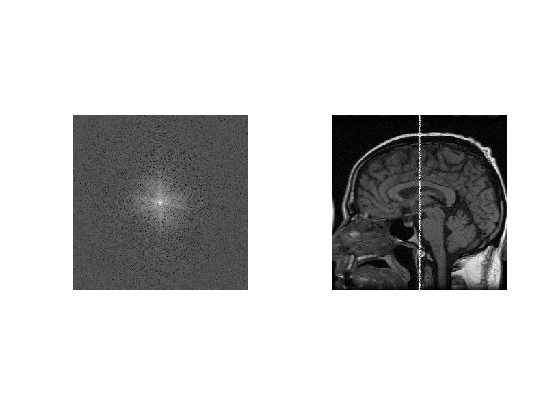

In [25]:
% RF interference - simulate frequency modulated interference
relative_RF_frequency = 1;
f = randn(S(1),1)*relative_RF_frequency/2;
data_rfint = exp(i*2*pi* f*[1:S(1)]/S(1)  ) *  max(abs(kdata(:)))/S(1)/1.5;
im_rfint = ifft2c(kdata + data_rfint);

figure
subplot(121)
imagesc(log(abs(kdata + data_rfint)), [0 max(log(abs(kdata(:))))])
colormap(gray), axis equal tight off
subplot(122)
imagesc(abs(im_rfint), [0 max(abs(im_original(:)))])
colormap(gray), axis equal tight off